<a href="https://colab.research.google.com/github/1doshi/nir/blob/main/Transformer_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# download the train and test dataset from torchvison
train_dataset = MNIST(root="./dataset/", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root="./dataset/", train=False, download=True, transform=ToTensor())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [3]:
import torch
import torch.nn as nn

Основным компонентом блока Multi-Head Attention является Scaled Dot-Product Attention. Сначала входной вектор Z дублируется 3 раза и умножается на веса Wq, Wk и Wv, чтобы получить запросы, ключи и значения соответственно. Затем запросы умножаются на ключи, а результат делится на квадратный корень измерения, чтобы избежать проблемы исчезающего градиента. Эта матрица проходит через слой Softmax и умножается на значения, чтобы дать нам окончательный результат, называемый Head H.
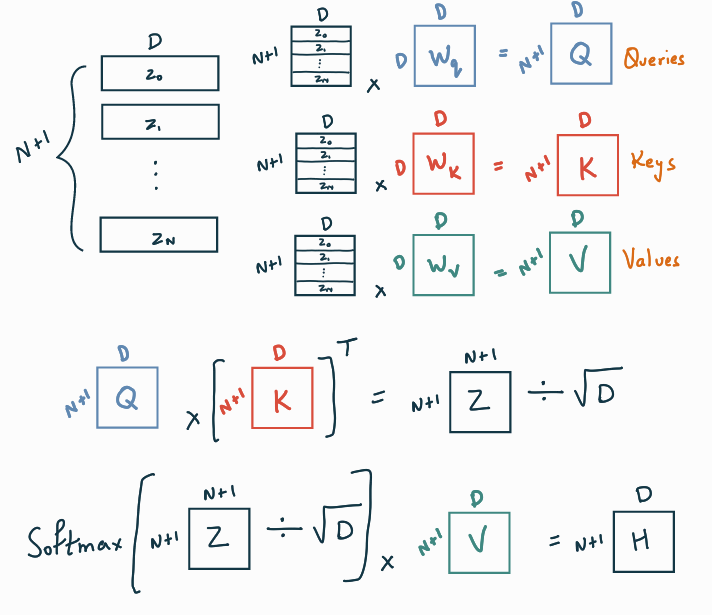

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        
        # Каждый из этих трех входов подвергается линейному преобразованию:
        # это повторяется для каждой head. Слои nn.Linear, по сути, 
        # являются линейными преобразованиями вида Ax + b.

        self.q_weights = [nn.Linear(hidden_dim, hidden_dim) for _ in range(self.num_heads)]
        self.k_weights = [nn.Linear(hidden_dim, hidden_dim) for _ in range(self.num_heads)]
        self.v_weights = [nn.Linear(hidden_dim, hidden_dim) for _ in range(self.num_heads)]
        self.softmax = nn.Softmax(dim=-1)
        self.linear = nn.Linear(num_heads*hidden_dim, hidden_dim)
        
    def forward(self, X):
        #B, N, D = X.shape 
        result = []
        for x in X:
            x_result = [] # H, N, D
            for head in range(self.num_heads):
                q = self.q_weights[head](x)
                k = self.k_weights[head](x)
                v = self.v_weights[head](x)
                h = self.softmax(q @ k.T / self.hidden_dim**2) @ v # N, D
                x_result.append(h)
            result.append(torch.hstack(x_result)) # B, H, N, D
        H = torch.cat([torch.unsqueeze(r, dim=0) for r in result]) 
        out = self.linear(H)
        return out # N, D

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, img_shape, patch_size, hidden_dim, num_heads, out_dim, num_encoder_blocks=6):
        super().__init__()
        
        self.img_shape = img_shape
        self.patch_size = img_shape[0]*patch_size[0]*patch_size[1]
        self.num_patches = int(img_shape[0]*img_shape[1]/patch_size[0]) ** 2
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.out_dim = out_dim
        self.num_encoder_blocks = num_encoder_blocks
        
        # Linear patching
        self.linear_patching = nn.Linear(self.patch_size, self.hidden_dim)
        
        # CLS embedding
        self.cls_embedding = nn.Parameter(torch.rand(1, self.hidden_dim))
        
        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.rand(1+self.num_patches, self.hidden_dim))
        
        # Transformer
        self.transformer_1 = nn.Sequential(
                                nn.LayerNorm((1+self.num_patches, self.hidden_dim)),
                                MultiHeadSelfAttention(self.hidden_dim, self.num_heads)
                            )
        self.transformer_2 = nn.Sequential(
                                nn.LayerNorm((1+self.num_patches, self.hidden_dim)),
                                nn.Linear(self.hidden_dim, self.hidden_dim),
                            )
        
        # MLP head
        self.mlp_head = nn.Sequential(
                            nn.Linear(self.hidden_dim, self.out_dim),
                            nn.Tanh(),
                        )
    
    def forward(self, X):
        N, C, H, W = X.shape
        patches = X.reshape(N, self.num_patches, self.patch_size)
        E = self.linear_patching(patches)
        cls_embedding = nn.Parameter(self.cls_embedding.repeat(N, 1, 1))
        E = torch.cat([cls_embedding, E], dim=1)
        Epos = nn.Parameter(self.pos_embedding.repeat(N, 1, 1))
        Z = E + Epos
        for _ in range(self.num_encoder_blocks):
            res1 = self.transformer_1(Z)
            Z = self.transformer_2(res1 + Z)
        C = self.mlp_head(Z[:, 0])
        return C
                

In [6]:
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.01

img_shape = [1,28,28]
patch_size = [4,4]
hidden_dim = 8
num_heads = 3
out_dim = 10

In [7]:
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader
import numpy as np

np.random.seed(24)
torch.manual_seed(24)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

model = VisionTransformer(img_shape, patch_size, hidden_dim, num_heads, out_dim)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

for epoch in range(EPOCHS):
    train_losses = []
    correct = 0
    total = 0
    for batch_id, batch_sample in enumerate(train_loader):
        data, target = batch_sample 
        
        optimizer.zero_grad()               # avoid gradient accumulation
        output = model(data)                # forward pass
        loss = criterion(output, target)    # compute loss
        loss.backward()                     # backward pass - compute gradients
        train_losses.append(loss.item())    # storing loss
        optimizer.step()                    # backward pass - update parameters
        
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += len(target)
    train_loss = float(np.mean(train_losses))
    train_acc = 100 * correct / total
    print('\nTrain set: Epoch: {}, Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        epoch+1, train_loss, correct, total, train_acc))


Train set: Epoch: 1, Average loss: 1.4837, Accuracy: 30452/60000 (50.75%)

Train set: Epoch: 2, Average loss: 1.1498, Accuracy: 47349/60000 (78.92%)

Train set: Epoch: 3, Average loss: 1.0749, Accuracy: 50814/60000 (84.69%)

Train set: Epoch: 4, Average loss: 1.0350, Accuracy: 52283/60000 (87.14%)

Train set: Epoch: 5, Average loss: 1.0083, Accuracy: 53139/60000 (88.56%)


In [8]:
# Saving trained model to avoid re-training again
torch.save(model.state_dict(), "vit_mnist")

In [9]:
# Test Loop
with torch.no_grad():
    test_losses = []
    correct = 0
    for batch_id, batch_sample in enumerate(test_loader):
        data, target = batch_sample 

        optimizer.zero_grad()               # avoid gradient accumulation
        output = model(data)                # forward pass        
        loss = criterion(output, target)    # compute loss
        test_losses.append(loss.item())     # storing loss
        
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

    test_loss = float(np.mean(test_losses))
    test_acc = 100 * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(test_loader.dataset), train_acc))


Test set: Average loss: 1.0083, Accuracy: 9053/10000 (88.56%)
